In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar -xvf spark-3.3.1-bin-hadoop3.tgz
!pip install findspark


--2022-12-15 21:51:55--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.1-bin-hadoop3.tgz’

spark-3.3.1-bin-had 100%[===================>] 285.48M   168MB/s    in 1.7s    

2022-12-15 21:51:57 (168 MB/s) - ‘spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.1

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [3]:
import findspark
findspark.init()

In [4]:
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pyspark.sql.functions as functions
import string
import re

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Upload file and then create a PySpark dataframe by using the read.json() function. 

In [6]:
from google.colab import files
uploaded = files.upload() 

Saving Luxury_Beauty_5.json to Luxury_Beauty_5.json


In [8]:
# Upload a file withe the data on it and 
file_name = "Luxury_Beauty_5.json"
reviews_df = spark.read.json(file_name)
reviews_df.first().reviewText

'This handcream has a beautiful fragrance. It doesnt stay on or protect your hands through washing.  This size is quite small.'

# Pre-Cleaning: Explore data to see its attributes and values

In [77]:
reviews_df.show()

+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|   reviewerName|               style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+--------------------+--------------+--------+----+
|B00004U9V2| null|    5.0|This handcream ha...| 01 5, 2018|A2HOI48JK8838M|             DB|{null, null, null...| Beautiful Fragrance|    1515110400|    true|null|
|B00004U9V2| null|    5.0|wonderful hand lo...| 04 5, 2017|A1YIPEY7HX73S7|          Ajaey|{null, null, null...|wonderful hand lo...|    1491350400|    true|null|
|B00004U9V2| null|    5.0|Best hand cream a...|03 27, 2017|A2QCGHIJ2TCLVP|       D. Jones|{null, null, null...|Best hand cream a...|    1490572800|    true|null|
|B00004U9V2| null|    5.0|  

Only the review text and it's overall score matter in this case. So we will remove all other attributes. 

In [78]:
data = reviews_df.select(col("reviewText").cast(StringType()), col("overall").alias("score").cast("int"))
data.show(n=20)

+--------------------+-----+
|          reviewText|score|
+--------------------+-----+
|This handcream ha...|    5|
|wonderful hand lo...|    5|
|Best hand cream a...|    5|
|            Thanks!!|    5|
|Great hand lotion...|    5|
|Great product. Do...|    5|
|Great product. Do...|    5|
|Just as described...|    5|
|Nice lightweight ...|    4|
|Best hand cream e...|    5|
|Best hand cream e...|    5|
|BEST hand cream e...|    5|
|'Love this stuff....|    5|
|I like the cream ...|    5|
|There is no evide...|    3|
|I LOVE this scent...|    5|
|The Best Hand Cre...|    5|
|Amazing ....my fa...|    5|
|My sons favorite ...|    5|
|This hand cream i...|    5|
+--------------------+-----+
only showing top 20 rows



This is the distribution of rating counts. 

<BarContainer object of 5 artists>

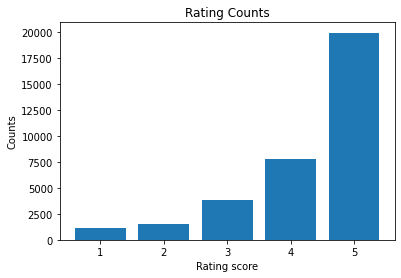

In [79]:
import collections
import matplotlib.pyplot as plt

scores = [val.score for val in data.select("score").collect()]
score_counts = collections.Counter(scores)
plt.title("Rating Counts")
plt.ylabel("Counts")
plt.xlabel("Rating score")
plt.bar(score_counts.keys(), score_counts.values())

## Cleaning Process

In [80]:
# This dictionary will be used in the cleaning step to remove and abbreviations in the review text. 
abbreviation_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",

    "i've":"i have",
    "ive":"i have",
    "we've":"we have",
    "weve":"we have",
    "youve":"you have",
    "youve":"you have",
    "they've":"they have",
    "theyve":"they have",
    "who've":"who have",
    "whove":"who have",
    "would've":"would have",
    "wouldve":"would have",
    "not've":"not have",

    "i'll":"i will",
    "ill":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "youll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "itll":"it will",
    "they'll":"they will",
    "theyll":"they will",

    "n": "and",

    "isn't":"is not",
    "isnt":"is not",
    "wasn't":"was not",
    "wasnt":"was not",
    "aren't":"are not",
    "arent":"are not",
    "weren't":"were not",
    "werent":"were not",
    "can't":"can not",
    "cant":"can not",
    "couldn't":"could not",
    "couldnt":"could not",
    "don't":"do not",
    "dont":"do not",
    "didn't":"did not",
    "didnt":"did not",
    "shouldn't":"should not",
    "shouldnt":"should not",
    "wouldn't":"would not",
    "wouldnt":"would not",
    "doesn't":"does not",
    "doesnt":"does not",
    "haven't":"have not",
    "havent":"have not",
    "hasn't":"has not",
    "hasnt":"has not",
    "hadn't":"had not",
    "hadnt":"had not",
    "won't":"will not",
    "wont":"will not",
}

In [81]:
def clean_string(review_string):
  if review_string is not None:
    """
    Look at words for needed cleaning before modeling
    """
    review_string = re.sub("[^a-zA-Z ]", "", review_string) # Remove any non alphabet letters 
    review_string = review_string.lower().strip() # turn to lower case and remove any whitespace
    review_string = ' '.join([abbreviation_dict.get(i, i) for i in review_string.split()]) #Replace abbreviations 

    return review_string

data = data.filter((functions.col('score')!=3)) # Remove any neutral reviews. 
data = data.filter(col("reviewText").isNotNull()) # Remove any null values 

# Create UDF Functions for text processing: Convert to lower case, Remove Punctuations and alphanumeric words

data_udf = udf(lambda x: 1 if x > 3 else 0)  # Give it a positive(1) or negative(0) label depending on its score
clean_string_udf = udf(lambda x: clean_string(x), StringType()) # Proceed with cleaning the strings

data = data.withColumn("true_label", data_udf(data['score'])).withColumn("reviewText", clean_string_udf(data['reviewText']))

# Post-Cleaning: Review text and label distribution after cleaning and labeling were done

In [82]:
data.select("reviewText").show(truncate=False, n=30)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<BarContainer object of 2 artists>

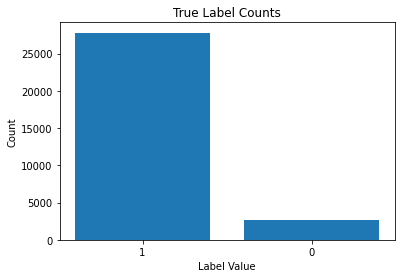

In [83]:
labels = [val.true_label for val in data.select("true_label").collect()]
labels_counts = collections.Counter(labels)
plt.title("True Label Counts")
plt.ylabel("Count")
plt.xlabel("Label Value")
plt.bar(labels_counts.keys(), labels_counts.values())

# Preparing Data For Modelling

 We use a 70-30 split for the training and testing sets, respectively

In [84]:
train, test = data.randomSplit([0.7,0.3])
print("Original Data size: ", (data.count(), len(data.columns))) 
print("Training Data size: ", (train.count(), len(train.columns)))
print("Test Data size: ", (test.count(), len(test.columns)))

Original Data size:  (30385, 3)
Training Data size:  (21243, 3)
Test Data size:  (9142, 3)


In [85]:
train.show()

+--------------------+-----+----------+
|          reviewText|score|true_label|
+--------------------+-----+----------+
|                    |    4|         1|
|a beautiful bottl...|    4|         1|
|a beautiful light...|    4|         1|
|a bit about me i ...|    4|         1|
|a bit darker than...|    4|         1|
|a bit expensive f...|    5|         1|
|a bit more expens...|    4|         1|
|a bit pricey but ...|    5|         1|
|a bit pricey but ...|    5|         1|
|a bit pricey for ...|    4|         1|
|a bit too pricey ...|    4|         1|
|a body washshampo...|    4|         1|
|a bright yet deep...|    5|         1|
|a bright yet deep...|    5|         1|
|a classic delicio...|    5|         1|
|a classic nudesli...|    5|         1|
|a classic nudesli...|    5|         1|
|a cleanser is sup...|    1|         0|
|a cleargel facial...|    4|         1|
|a couple of month...|    5|         1|
+--------------------+-----+----------+
only showing top 20 rows



In [86]:
test.show()

+--------------------+-----+----------+
|          reviewText|score|true_label|
+--------------------+-----+----------+
|a another great p...|    5|         1|
|a bit thick but f...|    5|         1|
|a clear serum tha...|    5|         1|
|a decent basic bl...|    4|         1|
|a few minutes ago...|    5|         1|
|a few things you ...|    5|         1|
|a friend of mine ...|    5|         1|
|a gentle calming ...|    4|         1|
|a good many years...|    4|         1|
|a great fall colo...|    5|         1|
|a great product t...|    5|         1|
|a great way to sa...|    5|         1|
|a little bit goes...|    5|         1|
|a little bit of t...|    5|         1|
|  a little expensive|    4|         1|
|a little goes a l...|    5|         1|
|a little goes a l...|    2|         0|
|a little goes a l...|    5|         1|
|a little less har...|    5|         1|
|a little too expe...|    4|         1|
+--------------------+-----+----------+
only showing top 20 rows



Tokenizing the training set using the PySpark Tokenizer

In [87]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="reviewWords")
tokenizedTrain = tokenizer.transform(train)
tokenizedTrain.show(truncate=False,n=15) 

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Remove any stop words from the tokenized training set

In [88]:
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=15)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Use the HashingTF function for feature extraction from the words

In [89]:
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrain = hashTF.transform(SwRemovedTrain).select('true_label', 'MeaningfulWords', 'features')
numericTrain.show(truncate=False, n=10)
numericTrain

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

DataFrame[true_label: string, MeaningfulWords: array<string>, features: vector]

Final training set with the appropriate data attributes and types for the model

In [90]:
numericTrain = numericTrain.withColumn("true_label",numericTrain.true_label.cast(IntegerType()))
numericTrain.show(truncate=False, n=10)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Model training, test data preperation and predictions

In [91]:
#Training Model using Logistic Regression
lr = LogisticRegression(labelCol="true_label", featuresCol="features", maxIter=20, regParam=0.01) 
model = lr.fit(numericTrain) # Fit the training data

In [92]:
#Prepare Testing data by tokenizing, removing stop words and feature extraction
tokenizedTest = tokenizer.transform(test)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest)
numericTest = numericTest.drop("score")
numericTest.show(truncate=False, n=2)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [93]:
# Prediction of the test set
raw_prediction = model.transform(numericTest)
raw_prediction.printSchema()
raw_prediction = raw_prediction.withColumnRenamed("true_label", "label")
raw_prediction = raw_prediction.withColumn("label",raw_prediction.label.cast(IntegerType()))
raw_prediction.show(truncate=False, n=2)

root
 |-- reviewText: string (nullable = true)
 |-- true_label: string (nullable = true)
 |-- reviewWords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MeaningfulWords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [94]:
# Get the meaningful columns from the raw prediction data
Final_prediction = raw_prediction.select("MeaningfulWords", "prediction", "label")
Final_prediction.show(n=20, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Accuracy, Precision, and Recall calculations

In [95]:
Total_True=Final_prediction.filter(Final_prediction['prediction']==Final_prediction['label']).count()
Alldata=Final_prediction.count()
Accuracy=Total_True/Alldata # Count of True Positives / Count of all predictions
print("Accuracy Score is:", Accuracy*100, '%')

Accuracy Score is: 93.94005688033253 %


In [96]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(raw_prediction))

Test Area Under ROC 0.8990329978262251


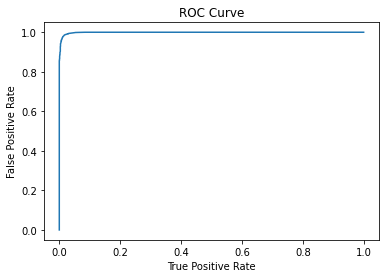

Training set areaUnderROC: 0.9989163247336409


In [97]:
import matplotlib.pyplot as plt
import numpy as np

trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

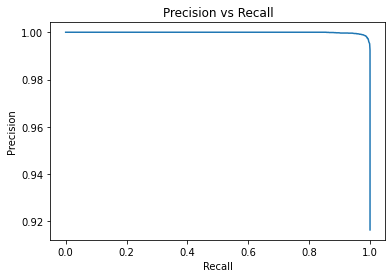

In [98]:
# Plot recall and precision values
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title("Precision vs Recall")
plt.show()